# Hull and White model

In this post, I discuss how to implement Hull and White short term interest rate model.

The short rate is assumed to satisfy the following stochastic diﬀerential equation

$$ dr_t = (\theta(t) - k r_t)dt + \sigma dW_t  $$

The price of a zero coupon bond is

\begin{equation}
P(t,T) = e^{A(t,T) -B(T-t)r_0}
\end{equation}

where $r_0$ is the current level of (short term) interest rates and,

<br>
\begin{equation}
A(t, T) = -\int_t^{T}B\left(T-s\right)\theta_sds+\frac{\sigma^2}{2}\int_t^{T}B\left(T-s\right)^2ds\end{equation}
<br>

<br>
\begin{equation}
B(t, T) = \frac{1}{k}\left(1-e^{-k(T-t)}\right)\end{equation}
<br>


\begin{equation}
\theta(t) = \frac{{\partial}f(0,t)}{{\partial}t} + kf(0,t) + \frac{\sigma^2}{2k}\left(1-e^{-2kt}\right)
\end{equation}

$\theta(t)$ is the drift rate that matches the current term structure of interest rates 

Given the formula for the zero coupon bond, it is also possible to write the yield for a maturity $\tau$ using the short term rate $r_t$ at time $t$ as

<br>
\begin{equation}
Y(t,t+\tau) = -\frac{A(t,t+\tau)}{\tau} + \frac{1}{k}\left(\frac{1-e^{-2k\tau}}{\tau}\right)r_t
\end{equation}
<br>

#### Loading python libraries

In [1]:
import numpy as np
import numpy.random as npr
from   scipy import integrate
import scipy.integrate as sciIntegr
import pandas as pd
from   scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from Bond import *

In [3]:
dataframe    =  pd.DataFrame.from_csv('Strips.csv', index_col=None)
print (dataframe.shape)
dataframe.head(10)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


(78, 3)


,Time,Zeros,Prices
0,0.003968,0.011107,0.999956
1,0.347945,0.015111,0.994756
2,0.436447,0.016121,0.992989
3,0.524948,0.017110,0.991058
4,0.613450,0.018079,0.988971
5,0.701951,0.019027,0.986733
6,0.790452,0.019956,0.984350
7,0.878954,0.020864,0.981828
8,0.967455,0.021753,0.979174
9,1.055957,0.022623,0.976394


In [4]:
class HullWhite(Bond):
    def __init__(self, ZCB, times, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
    
        self.dt     = 0.00001
        self._ZCB   = ZCB
        self._times = times
        
        self.ret= splrep(self._times, -np.log(self._ZCB)/ self._times)                
        
    def fitting(self,x):
        return splev(x, self.ret)
    
    def dfitt(self,x):
        return splev(x, self.ret, der=1)
    
    def ForwardRate(self, time):                
        r        = self.SpotRate(time)
        dr_dt    = self.dfitt(time)
        
        fwd_rate = r + time * dr_dt                    
        return fwd_rate
    
    def SpotRate(self, time):            
        return self.fitting(time)        
    
    def PrepareThetas(self):
        Timeline        = np.linspace(Maturities[0], Maturities[-1],100)
        Thetarates      = [self.Thetat(t) for t in Timeline]
        self.Thetarates = splrep(Timeline, Thetarates)
        
    def A(self, t, T):                    
               
        def integrand1(time):
            theta = splev(time, self.Thetarates)
            return theta * self.B(time, T)
            
        def integrand2(time):
            return (self.B(time, T)**2)
        
        val1 = integrate.quad(integrand1, t, T)[0]
        val2 = integrate.quad(integrand2, t, T)[0]
        return -val1 + 0.5*(self.sigma**2)*val2
        
    def Yield(self, t, T, rate):
        res    = -self.A(t, T)/(T-t) + (1/self.kappa)*(1-np.exp(-self.kappa*(T-t))) * 1/(T-t)*rate
        return res
        
    def Thetat(self, time):  
        up       = np.max(time + self.dt,0)
        down     = np.max(time - self.dt,0)

        df       = self.ForwardRate(down) - self.ForwardRate(up)     
        df_dt    = -df/(2*self.dt)
        
        return df_dt + self.kappa*self.ForwardRate(time)+ (self.sigma**2)/(self.kappa*2)*(1-np.exp(-2*self.kappa*time))
        
    def ZCB_Forward_Integral(self,t, T):                                         
        val = integrate.quad(self.ForwardRate, t, T)[0]
        return np.exp(-val)    
    
    def B(self, t, T):
        return (1/self.kappa)*(1-np.exp(-self.kappa*(T- t)))
    
    def Exact_zcb(self, t, T):
        B = self.B(t, T)
        A = self.A(t, T)
        return np.exp(A-self.r0*B)
    
    def Euler(self, M, I, tau):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # tau is the maturity        
        dt = tau / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, tau, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = xh[t - 1] + (self.Thetat(self.times[t-1]) - self.kappa*xh[t - 1]) * dt + \
                  self.sigma * np.sqrt(dt) * npr.standard_normal(I)
        self.rates = xh
        
    def ExpectedRate(self,t, T):
        # this expectation if always from time t = 0
        def integrand(time):
            theta = splev(time, self.Thetarates)
            
            return theta * np.exp(-self.kappa*(T-time))
                    
        val = self.r0*np.exp(-(T-t)*self.kappa) + integrate.quad(integrand, t, T)[0]
        return val

In [5]:
Maturities = np.asarray(dataframe.Time)
Prices     = np.asarray(dataframe.Prices)
rate0      = -np.log(Prices[0])/Maturities[0]
print(rate0)

0.011106892675553953


In [6]:
r0    = rate0   # current level of rates
kappa = 0.19    # speed of convergence - Not required in Ho Lee Model
theta = ""      # long term rate       - Not required in Ho Lee Model
sigma = 0.0196  # vol    

In [7]:
# create an instance of the object HullWhite and calculate theta(t)
hullwhite = HullWhite(Prices,Maturities, theta, kappa, sigma,rate0)
hullwhite.PrepareThetas()

use some functions and check all is ok

In [8]:
print(-np.log(hullwhite.Exact_zcb(0,1)))
print(hullwhite.Yield(0,1,rate0))
print(-np.log(hullwhite.ZCB_Forward_Integral(0,1)))
print(dataframe.Zeros[9])
print(dataframe.Zeros[8])

0.022116360681915383
0.022116360681915352
0.02207551892796123
0.022623262999999998
0.021753417999999997


In [9]:
# The forward rate for the period t = 1, t= 2 is 
print(-np.log(hullwhite.ZCB_Forward_Integral(1,2)))

0.039447916443125924


In [10]:
# we can also use Hull and White ZCB formula to calculate the forward price for the period t = 1, t= 2 
print(hullwhite.Exact_zcb(0,2)/hullwhite.Exact_zcb(0,1))
print(hullwhite.ZCB_Forward_Integral(1,2))

0.9612881889886551
0.9613200216527579


### Plot spot, forward rates and $\theta(t)$

In [11]:
Timeline  = np.linspace(Maturities[0], Maturities[-1],100)
Fwdrates  = [hullwhite.ForwardRate(t) for t in Timeline]
Spotrates = [hullwhite.SpotRate(t) for t in Timeline]
Thetarates= [hullwhite.Thetat(t) for t in Timeline]
hullwhitePrices=[hullwhite.Exact_zcb(0, t) for t in Timeline]

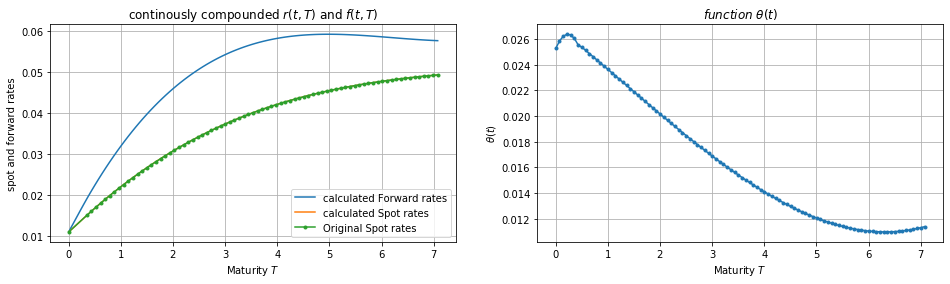

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(Timeline, Fwdrates, label ='calculated Forward rates')
plt.plot(Timeline, Spotrates, label='calculated Spot rates')
plt.plot(Maturities, -np.log(Prices)/Maturities, marker='.', label='Original Spot rates')
plt.xlabel(r'Maturity $T$ ')
plt.title(r'continously compounded $r(t,T)$ and $f(t,T)$')
plt.grid(True)
plt.legend()
plt.ylabel('spot and forward rates')

plt.subplot(122)
plt.plot(Timeline, Thetarates, marker='.',label =r'$\theta(t)$')
plt.xlabel(r'Maturity $T$') 
plt.title(r'$function$ $\theta(t)$')
plt.grid(True)
plt.ylabel(r'$\theta(t)$')
plt.show()


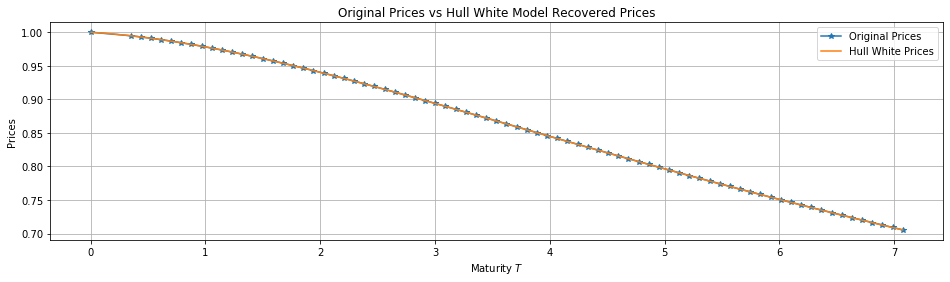

In [13]:
plt.figure(figsize=(16,4))

plt.plot(Maturities, Prices, marker='*', label = "Original Prices")
plt.plot(Timeline, hullwhitePrices, label ='Hull White Prices')

plt.xlabel(r'Maturity $T$ ')
plt.title(r'Original Prices vs Hull White Model Recovered Prices')
plt.grid(True)
plt.legend()
plt.ylabel('Prices')

plt.show()


### Now we simulate the short term rate with Hull White sde and price zero coupon bonds

We aim to recover the same prices we used as input  

Let's run the first check on the ZCB with a 5 yr maturity

In [14]:
tau = 5
I   = 10000       # no. of simulations
M   = tau * 252   # trading day per annum

In [15]:
# So we always use the same random numbers
npr.seed(1500)

In [16]:
# run the sde
%time hullwhite.Euler(M, I, tau)

Wall time: 700 ms


In [17]:
vals = hullwhite.StochasticPrice(hullwhite.rates, hullwhite.times)

In [18]:
print("the price is:      ", vals[0])
print("the price +2sd is :", vals[1])
print("the price -2sd is :", vals[2])
print("the Analytic price is :", hullwhite.Exact_zcb(0, 5))

the price is:       0.7951012934582304
the price +2sd is : 0.7965295568580492
the price -2sd is : 0.7936730300584117
the Analytic price is : 0.796529426858124


All fine! We are ready to run simuations and price all our input ZCBs  

In [19]:
# So we always use the same random numbers
npr.seed(1500)

size   = (Prices.shape[0])
Result = np.zeros((size, 6))
for i, j in enumerate(Maturities):
    tau = j
    M   = tau * 252
    hullwhite.Euler(M, I, tau)
    vals = hullwhite.StochasticPrice(hullwhite.rates, hullwhite.times)
    Result[i,0] = np.round(j,5)
    Result[i,1] = np.round(vals[0],4)
    Result[i,2] = np.round(vals[1],4)
    Result[i,3] = np.round(Prices[i],4)
    Result[i,4] = np.round(hullwhite.Exact_zcb(0,j),4)
    Result[i,5] = np.round(vals[2],4)

see the results

In [20]:
Result = pd.DataFrame(Result)
Result.columns = ['Maturity','MC Price','MC Price+2CD', 'Original Price', 'hullwhite Price', 'MC Price-2CD',]
Result.tail(10)

,Maturity,MC Price,MC Price+2CD,Original Price,hullwhite Price,MC Price-2CD
68,6.27754,0.7400,0.7417,0.7390,0.7389,0.7382
69,6.36604,0.7356,0.7374,0.7352,0.7351,0.7339
70,6.45455,0.7319,0.7336,0.7314,0.7313,0.7301
71,6.54305,0.7272,0.7290,0.7277,0.7275,0.7254
72,6.63155,0.7235,0.7253,0.7239,0.7238,0.7217
73,6.72005,0.7201,0.7219,0.7202,0.7201,0.7183
74,6.80855,0.7167,0.7185,0.7166,0.7164,0.7148
75,6.89705,0.7107,0.7126,0.7129,0.7128,0.7089
76,6.98555,0.7080,0.7098,0.7093,0.7092,0.7061
77,7.07406,0.7051,0.7070,0.7057,0.7055,0.7033


### Let's find the one year forward price of a ZCB maturing in 5 years

We exploit the formula
<br>
\begin{equation}
Y(t,t+\tau) = -\frac{A(t,t+\tau)}{\tau} + \frac{1}{k}\left(\frac{1-e^{-2k\tau}}{\tau}\right)r_t
\end{equation}
<br>
in the introduction to recover the forward price of the ZCB with a 5 year to maturity. 

The idea is to simulate $dr(t)$ for one year and use the formula above to value the ZCB which has now a four year to maturity. 

In [21]:
# So we always use the same random numbers
npr.seed(1500)

I   = 10000     # no. of simulations
T_O = 1 # 1 year
T_M = 5 # 5 year
M   = T_O * 252 # trading day per annum
    
BondValue = ZCBValue(0) # an instance of class ZCBValue, to model the payoff value at year 1    
vals = hullwhite.FutureZCB(M,I, T_O, T_M, BondValue)

In [22]:
print( "----------------------------------------------------------------")
print("the MC price of a ZCB maturing in",T_M, "years is:", np.round(vals[0],4))
print("The ZCB price from Formulae is               ", np.round(hullwhite.Exact_zcb(0, 5),4))

print( "----------------------------------------------------------------")
print("the MC price +2sd is :", vals[1])
print("the MC price -2sd is :", vals[2])
print( "----------------------------------------------------------------")

print("the MC price of a ZCB maturing in",T_O, "year is:", np.round(vals[4],4))
print("The ZCB price from Formulae is              ", np.round(hullwhite.Exact_zcb(0, 1),4))

print( "----------------------------------------------------------------")
print("The MC Expected short term rate in",T_O,"year is ", np.round(vals[5],4))
print("The Expected short term rate in",T_O,"year is ", np.round(hullwhite.ExpectedRate(0,1),4))

print( "----------------------------------------------------------------")
print("the Price in",T_O,"year of a ZCB price maturing in",T_M,"years is", np.round(vals[3],4))
print("The fwd price from Formulae is                           ", np.round(hullwhite.Exact_zcb(0, 5)/hullwhite.Exact_zcb(0, 1),4))

----------------------------------------------------------------
the MC price of a ZCB maturing in 5 years is: 0.7967
The ZCB price from Formulae is                0.7965
----------------------------------------------------------------
the MC price +2sd is : 0.7976217862647464
the MC price -2sd is : 0.7957892218584118
----------------------------------------------------------------
the MC price of a ZCB maturing in 1 year is: 0.9782
The ZCB price from Formulae is               0.9781
----------------------------------------------------------------
The MC Expected short term rate in 1 year is  0.0321
The Expected short term rate in 1 year is  0.0321
----------------------------------------------------------------
the Price in 1 year of a ZCB price maturing in 5 years is 0.8141
The fwd price from Formulae is                            0.8143


### Let's price an option maturing in one year, on a zero coupon bond maturing in 5 years 

The idea is to simulate $dr(t)$ for one year, until the option matures, and use the same formula used previously to value the ZCB which has now a four year to maturity. Once we know the ZCB value, we can calculate the option payoff, and consequenttly discount it back using the simulated rates paths. 

We check the simulated result with the Analytic price 

In [23]:
# So we always use the same random numbers
npr.seed(1500)

I   = 10000   # no. of simulations
OptionStrike = 0.8
BondValue    = ZCBOption(OptionStrike) # an instance of class ZCBOption, to model the payoff value at year 1    

In [24]:
%time vals = hullwhite.FutureZCB(M,I, T_O, T_M, BondValue)

Wall time: 37.4 s


In [25]:
print( "------------------------------------------------------")
print("the MC price of an one year Option on a ZCB maturing in:",T_M, "years is:", np.round(vals[0],4))

print( "------------------------------------------------------")
print("the MC price +1.96sd is :", vals[1])
print("the MC price -1.96sd is :", vals[2])

print("The Analytic hullwhite Price is ", 0.024040) # Hull White Analytic Option model is not included. Price was taken from
# Fixed Income Securities, Pietro Veronesi, chapter 19, example 19.4, page 662 

------------------------------------------------------
the MC price of an one year Option on a ZCB maturing in: 5 years is: 0.0236
------------------------------------------------------
the MC price +1.96sd is : 0.024199908524697566
the MC price -1.96sd is : 0.023078667180169297
The Analytic hullwhite Price is  0.02404
